# Introduction
We are going to build the Value class of the micrograd library such that it automatically keeps track of our calculations such that we can easily calculate the derivatives of arbitrarily nested functions (e.g. neural networks).

# Libraries

In [1]:
%matplotlib inline

In [6]:
from __future__ import annotations

# Value Class
In this class we implement the simple math operations we saw in the first notebook as well as the backpropagation.

### Adding Addition and Multiplication
The math operations are added using the special/dunder methods recognized by starting and ending with \_\_.

In [7]:
# Implementing simple addition and multiplication
class Value:
    def __init__(self, data:float):
        self.data = data
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other:Value) -> Value:
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other:Value) -> Value:
        out = Value(self.data * other.data)
        return out

In [8]:
# Testing methods
print(Value(2) + Value(3))
print(Value(2) * Value(3))

Value(data=5)
Value(data=6)


### Keeping track of Expression Graphs
As mentioned in the first notebook our library needs to keep track of which values produce which other values before it can do backpropagation. This functionality is added here. Everytime an addition or multiplication has been performed the previous calculation is saved.

In [9]:
# Keeping track of previous calculations
class Value:
    def __init__(self, data:float, _children:tuple = (), _op:str = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other:Value) -> Value:
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other:Value) -> Value:
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [23]:
# Making Calculations
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c;print(d)

Value(data=4.0)


In [24]:
# Investigating the numbers were calculated
print(f'Previous calculation for d: {d._prev}')
print(f'Previous calculation for d: {d._op}')

print(f'Previous calculation for value 1: {list(d._prev)[0]._prev}')
print(f'Previous calculation for value 1: {list(d._prev)[0]._op}')

print(f'Previous calculation for value 2: {list(d._prev)[1]._prev}')
print(f'Previous calculation for value 2: {list(d._prev)[1]._op}')

Previous calculation for d: {Value(data=10.0), Value(data=-6.0)}
Previous calculation for d: +
Previous calculation for value 1: set()
Previous calculation for value 1: 
Previous calculation for value 2: {Value(data=2.0), Value(data=-3.0)}
Previous calculation for value 2: *


The tracking shows that d was calculated from two numbers: 10 and -6. We can further see that -6 was calculated by multiplying 2 and -3. It looks like the hierachical calculations are now correctly tracked. 

### Visualizing Expression Graphs
As the manuel walkthrough of previous calculations above is rather annoying to perform, here we use the **graphviz**-library to visualise the calculations instead.

In [25]:
from graphviz import Digraph

In [26]:
def trace(root: Value) -> tuple:
    """
    Description:
        Iterates recursively through the previous calculations
        from the root to the leafs and creates a tree.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        Nodes and Edges representing the calculations
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [27]:
def draw_dot(root: Value) -> Digraph:
    """
    Description:
        Creates a graph showing the relations between calculations.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        A graph representation of the calculations        
    """
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        # For each value in graph create rectangular node for it
        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        
        # If the value is a result of a calculation create a "operation" node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # Connect the n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

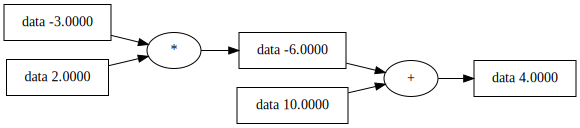

In [28]:
# Plotting calculation graph
draw_dot(d)

### Adding backpropagation
Now we add tracking of the gradients to the class, as well as the visualization. For a recap on **The Chain Rule** go to notebook 2. Intuitively the chain rule can be explained in the following way:

"if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In [29]:
def trace(root: Value) -> tuple:
    """
    Description:
        Iterates recursively through the previous calculations
        from the root to the leafs and creates a tree.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        Nodes and Edges representing the calculations
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [44]:
def draw_dot(root: Value) -> Digraph:
    """
    Description:
        Creates a graph showing the relations between calculations.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        A graph representation of the calculations        
    """
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        # For each value in graph create rectangular node for it
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        # If the value is a result of a calculation create a "operation" node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # Connect the n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [48]:
# Keeping track of gradients
class Value:
    def __init__(self, data:float, _children:tuple = (), _op:str = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lamda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other:Value) -> Value:
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other:Value) -> Value:
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def backward():
        

In [49]:
# Making Calculations
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b + c;d.label='d';print(d)

Value(data=4.0)


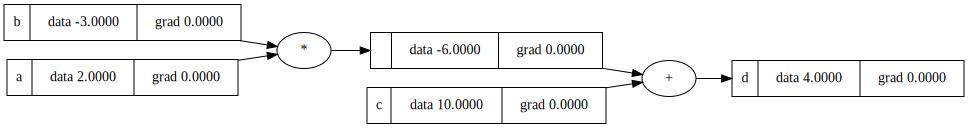

In [50]:
# Visualizing 
draw_dot(d)

In [ ]:
#http://www.youtube.com/watch?v=VMj-3S1tku0&t=70m26s

### Creating a Neuron
Here we make a simple neuron and shows the graph.

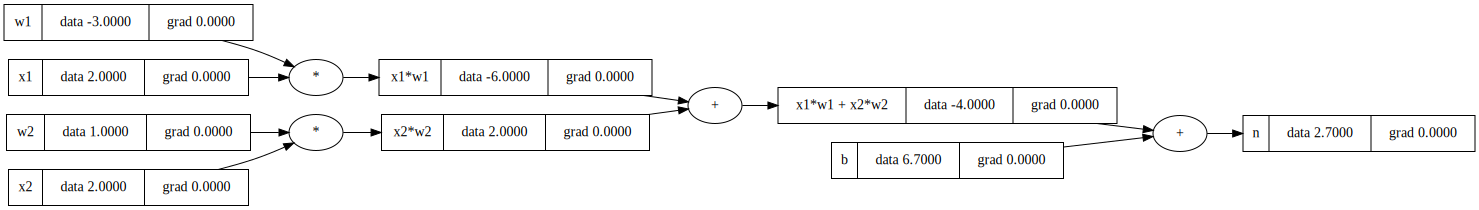

In [72]:
# Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(2.0, label = 'x2')

# Weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# Bias
b = Value(6.7, label = 'b')

# Forward pass
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

# Writing Cells to Module

In [24]:
!python3.10 ../../helpers/ipynb_to_py.py 3.\ Value\ Module.ipynb "###VALUE###" ../../modules/Micrograd/value.py

INFO: Cells with label ###VALUE### extracted from 3. Value Module.ipynb
